In [157]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers # type: ignore
from tensorflow.keras import models # type: ignore
from IPython import display
tf.keras.layers

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [158]:
DATASET_PATH = 'train/audio'
data_dir = pathlib.Path(DATASET_PATH)

TEST_PATH = 'test'
test_dir = pathlib.Path(TEST_PATH)

In [159]:
words = np.array(tf.io.gfile.listdir(str(data_dir)))
words = np.delete(words, np.where(words == '_background_noise_'))
print('Commands:', words)

Commands: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


In [160]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64721 files belonging to 30 classes.
Using 51777 files for training.
Using 12944 files for validation.

label names: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


In [161]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    batch_size=64,
    shuffle=False,
    class_names=None,
    output_sequence_length=16000)


Found 9999 files belonging to 1 classes.


In [162]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [163]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)


In [164]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [165]:
label_names[[1,1,3,0]]

array(['bird', 'bird', 'dog', 'bed'], dtype='<U6')

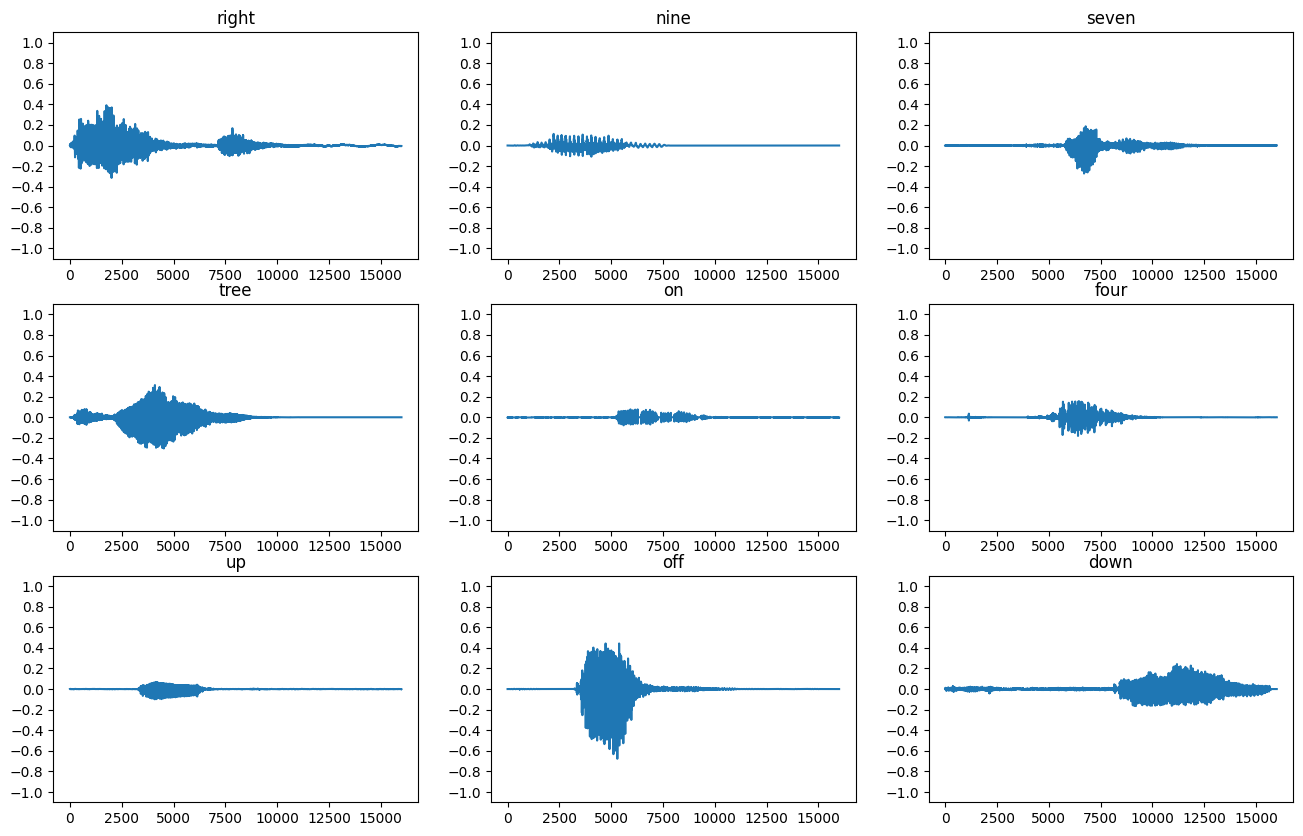

In [166]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [167]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [168]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: seven
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [169]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

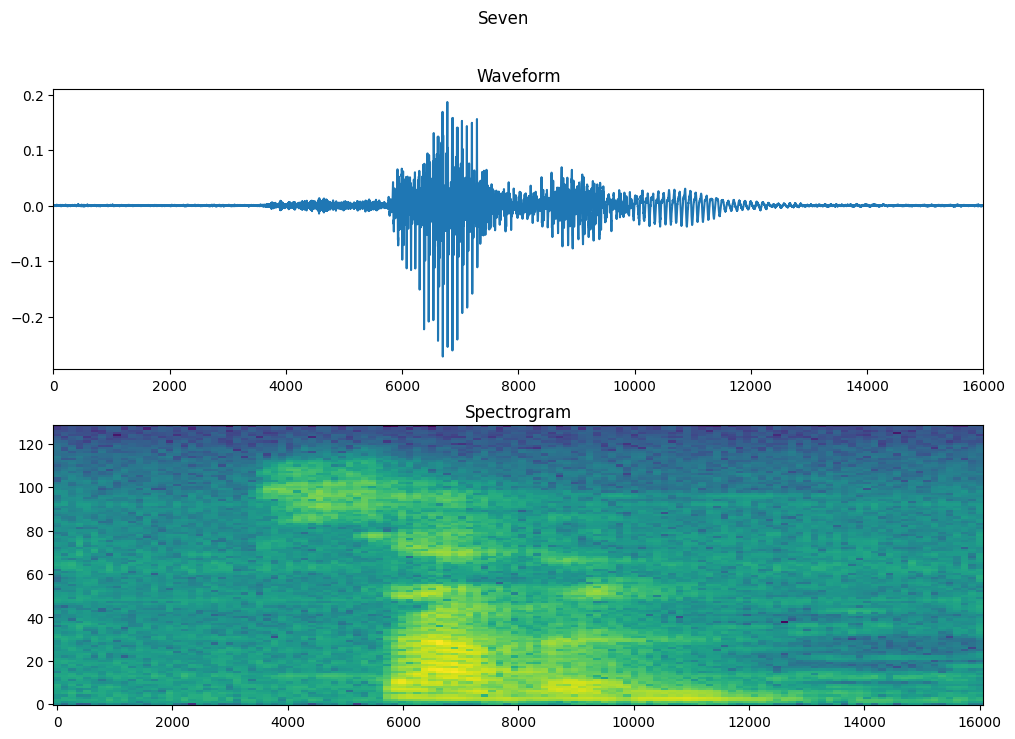

In [170]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [171]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [172]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [173]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

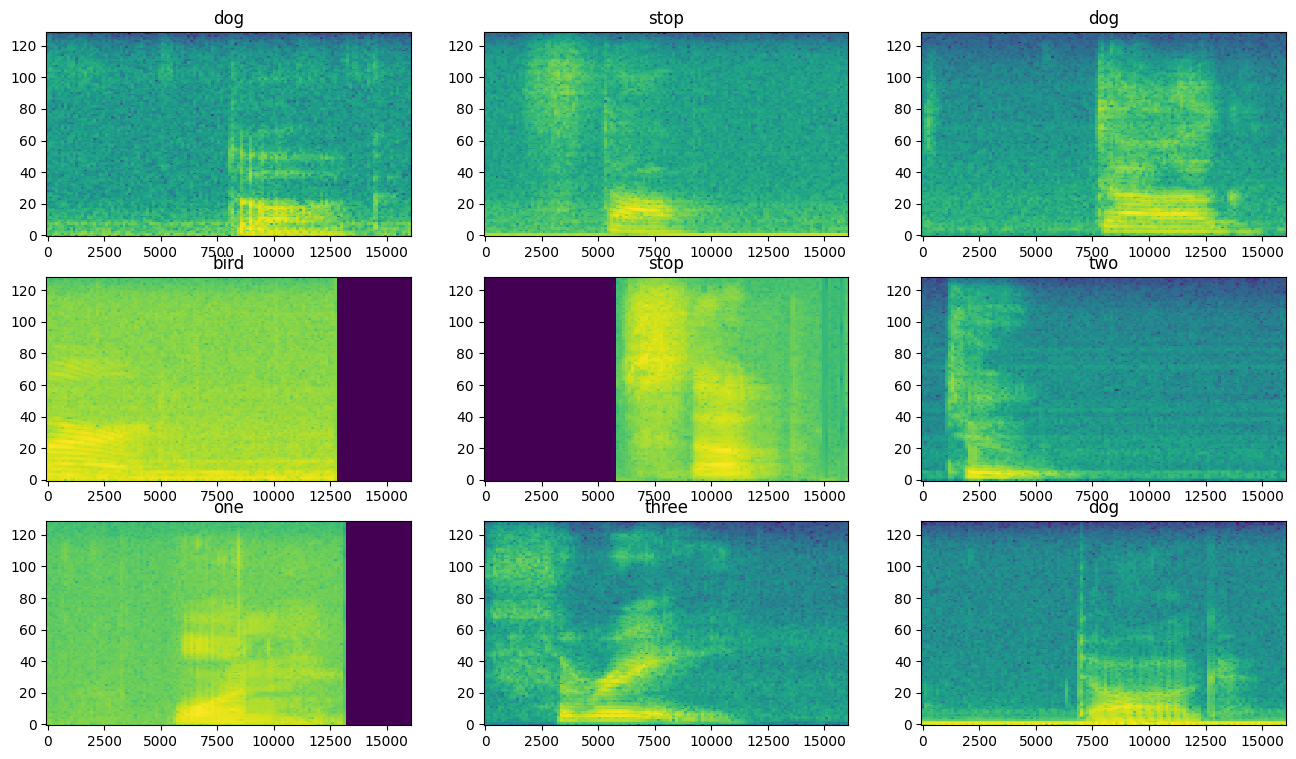

In [174]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [175]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [176]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,449 (6.21 MB)

 Trainable params: 1,628,446 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

In [177]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [178]:
EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
INFO:tensorflow:Error reported to Coordinator: `colocate_vars_with` must only be passed a variable created in this tf.distribute.Strategy.scope(), not: <tf.Variable 'sequential_3/conv2d_6/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
Traceback (most recent call last):
  File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\tensorflow\python\training\coordinator.py", line 293, in stop_on_exception
    yield
  File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\tensorflow\python\distribute\mirrored_run.py", line 387, in run
    self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_st

ValueError: in user code:

    File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data  **
        return self.train_step(data)
    File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 73, in train_step
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))
    File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 344, in apply_gradients
        self.apply(grads, trainable_variables)
    File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 383, in apply
        self.build(trainable_variables)
    File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\keras\src\optimizers\adam.py", line 97, in build
        self.add_variable_from_reference(
    File "c:\Users\herma\anaconda3\envs\ml\Lib\site-packages\keras\src\backend\tensorflow\optimizer.py", line 34, in add_variable_from_reference
        with self._distribution_strategy.extended.colocate_vars_with(

    ValueError: `colocate_vars_with` must only be passed a variable created in this tf.distribute.Strategy.scope(), not: <tf.Variable 'sequential_3/conv2d_6/kernel:0' shape=(3, 3, 1, 32) dtype=float32>


Text(0, 0.5, 'Accuracy [%]')

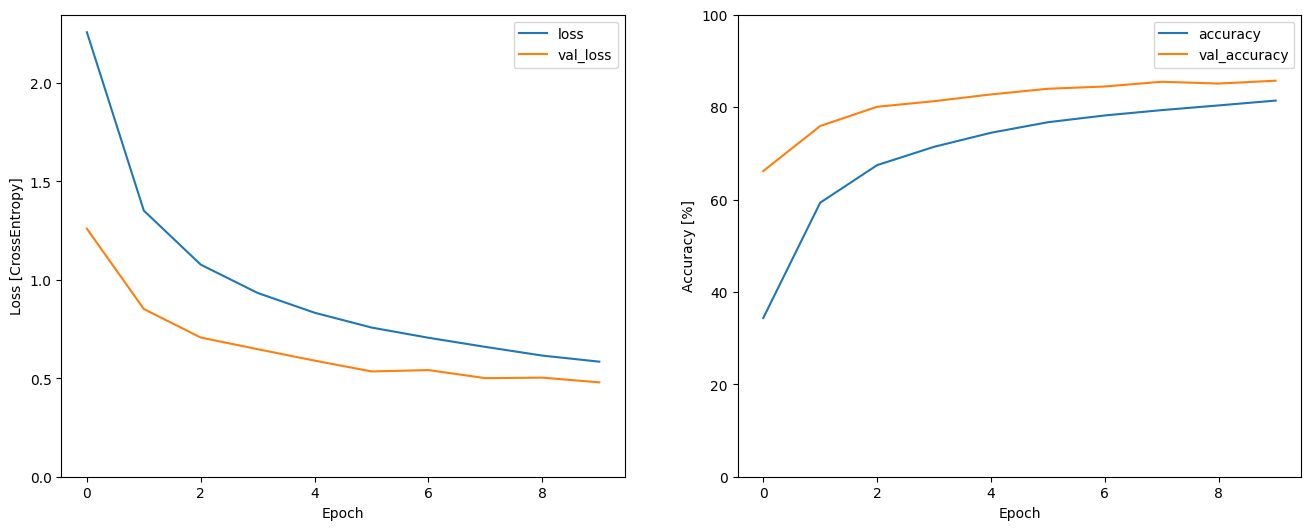

In [125]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [129]:
model.evaluate(test_spectrogram_ds, return_dict=True)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8561 - loss: 0.4826


{'accuracy': 0.8541666865348816, 'loss': 0.49031946063041687}

In [128]:
model.predict(test_spectrogram_ds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


array([[-18.282633  , -15.422367  ,  -1.7011288 , ..., -20.76557   ,
        -19.938465  ,  -1.1896291 ],
       [ -1.5515963 ,  -5.25026   ,  -0.65075284, ..., -13.765879  ,
         -8.701246  ,  -5.4755516 ],
       [ -0.784749  , -12.784206  ,  12.508869  , ..., -16.019854  ,
         -1.5118402 , -15.20115   ],
       ...,
       [ -5.5790296 ,  -3.4770262 ,  -3.1037104 , ..., -25.18396   ,
        -17.381039  ,   2.1341865 ],
       [ -2.1018724 ,  -5.9325905 ,  -0.4777042 , ...,  -6.53272   ,
         -3.0537748 ,   2.0366    ],
       [ -7.4048915 ,  10.155228  ,  -8.407771  , ..., -13.89617   ,
        -13.2458105 ,  -5.4436707 ]], dtype=float32)